In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
diamonds = pd.read_csv('diamonds_renamed_cols.csv')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,lenght_x,width_y,depth_z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Remove 'depth' and 'table' as they are not going to very useful in estimating diamonds price

In [3]:
diamonds.drop(['depth', 'table'], axis=1, inplace=True)

In [4]:
diamonds.head()

,carat,cut,color,clarity,price,lenght_x,width_y,depth_z
0,0.23,Ideal,E,SI2,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,335,4.34,4.35,2.75


### split dataset to train and test set

Create X and y

In [5]:
X = diamonds.drop('price', axis=1)
y = diamonds['price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### run Ordinal encoder on cut, color, clarity

In [7]:
categories = [['Fair', 'Good', 'Very Good', 'Ideal', 'Premium'],
             ['D', 'E', 'F', 'G', 'H', 'I', 'J'],
             ['I1','SI2', 'SI1', 'VS2',  'VS1', 'VVS2', 'VVS1', 'IF']]

In [8]:
ordinal_encoder = OrdinalEncoder(categories=categories)

In [9]:
obj_cols = ['cut', 'color', 'clarity']

X_train_cat = X_train[obj_cols]
X_test_cat = X_test[obj_cols]

In [10]:
ordinal_encoder.fit(X_train_cat)
X_train_oe = pd.DataFrame(ordinal_encoder.transform(X_train_cat))
X_test_oe = pd.DataFrame(ordinal_encoder.transform(X_test_cat))

In [11]:
X_train_oe.index = X_train.index
X_train_oe.columns = X_train_cat.columns

X_test_oe.index = X_test.index
X_test_oe.columns = X_test_cat.columns

### Normalise numerical variables with StandardScaler

In [12]:
num_X_train = X_train.drop(obj_cols, axis=1)
num_X_test = X_test.drop(obj_cols, axis=1)

In [13]:
scaler = StandardScaler()
num_X_train_scaled = pd.DataFrame(scaler.fit_transform(num_X_train))
num_X_train_scaled.columns = num_X_train.columns
num_X_train_scaled.index = num_X_train.index

num_X_test_scaled = pd.DataFrame(scaler.transform(num_X_test))
num_X_test_scaled.columns = num_X_test.columns
num_X_test_scaled.index = num_X_test.index

### Merge categorical and numerical variables

In [14]:
X_train = pd.concat([num_X_train_scaled, X_train_oe], axis=1)
X_test = pd.concat([num_X_test_scaled, X_test_oe], axis=1)

## Models

### Linear Regression

In [19]:
lm = LinearRegression()
lm_model = lm.fit(X_train, y_train)
lm_pred = lm_model.predict(X_train)

In [21]:
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = np.sqrt(lm_mse)
lm_r2 = np.sqrt(r2_score((y_train),(lm_pred)))
print(f'RMSE: {lm_rmse}')
print(f'R2: {lm_r2}')

RMSE: 1228.9465826528424
R2: 0.9516626884222305


### Polynominal regression

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly=PolynomialFeatures(degree=3)


In [21]:
X_poly=poly.fit_transform(X_train)
print(X_poly.shape)

(43152, 120)


In [22]:
lm = LinearRegression()

In [23]:
lm.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
X_test_poly = poly.fit_transform(X_test)

In [25]:
y_pred = lm.predict(X_test_poly)

In [26]:
lm_mse = mean_squared_error(y_test, y_pred)
lm_rmse = np.sqrt(lm_mse)
lm_r2 = np.sqrt(r2_score((y_test),(y_pred)))
print(f'RMSE: {lm_rmse}')
print(f'R2: {lm_r2}')

RMSE: 623.9647613848542
R2: 0.9873925562170552


### Random Forest Regressor

In [27]:
rr  = RandomForestRegressor()
rr.fit(X_train,y_train)
y_pred = rr.predict(X_test)

In [28]:
predictions = pd.DataFrame(y_pred)

In [29]:
predictions.index = X_test.index

In [30]:
price = pd.DataFrame(y_test)

In [31]:
pred_df = pd.concat([X_test, predictions], axis=1)

In [32]:
pred_df = pd.concat([pred_df, price ], axis=1)

In [33]:
pred_df.tail()

,carat,lenght_x,width_y,depth_z,cut,color,clarity,0,price
49568,-0.267206,0.046395,0.085309,-0.277251,1.0,3.0,3.0,2225.73,2131
32163,-1.087096,-1.375993,-1.338138,-1.291499,3.0,2.0,7.0,714.12,787
52459,-0.204137,-0.193633,-0.209796,0.159439,0.0,2.0,3.0,2404.03,2516
15265,0.847005,1.059847,0.961944,0.934211,4.0,4.0,2.0,6083.45,6129
43028,-0.351297,-0.229193,-0.209796,-0.192731,3.0,5.0,2.0,1409.21,1372


In [34]:
rr_mse = mean_squared_error(y_test, y_pred)
rr_rmse = np.sqrt(rr_mse)
rr_r2 = np.sqrt(r2_score((y_test),(y_pred)))

In [35]:
print(f'RMSE: {rr_rmse}')
print(f'R2: {lm_r2}')

RMSE: 546.5922448175694
R2: 0.9873925562170552


In [36]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rr, X_test, y_test, n_repeats=30, random_state=0)

In [39]:
sorted_idx = r.importances_mean.argsort()

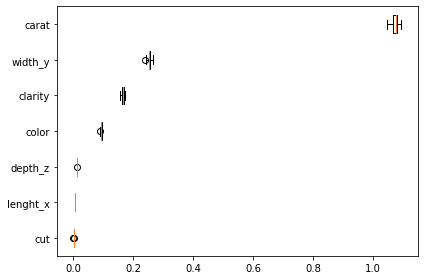

In [41]:
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
fig.tight_layout()
plt.show()

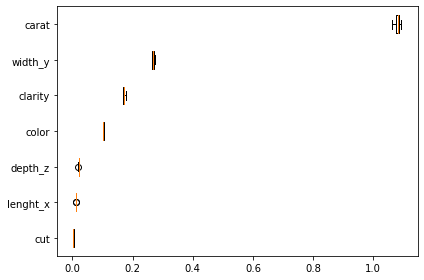

In [42]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rr, X_train, y_train, n_repeats=30, random_state=0)
sorted_idx = r.importances_mean.argsort()
fig, ax = plt.subplots()
ax.boxplot(r.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
fig.tight_layout()
plt.show()


### Lasso

In [60]:
lm_l = Lasso()
np.mean(cross_val_score(lm_l, X_train, y_train, scoring='neg_mean_absolute_error', cv=6))

-816.6511371386354

In [61]:
alpha = []
error = []

In [62]:
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=6)))
    

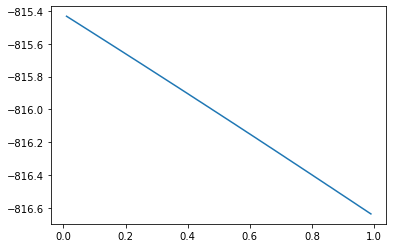

In [63]:
plt.plot(alpha, error)

### Batch gradient descent

In [64]:
from sklearn.linear_model import SGDRegressor
sgd_reg  = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.01)
sgd_reg.fit(X_train,y_train)
y_pred = sgd_reg.predict(X_test)

In [65]:
sgd_mse = mean_squared_error(y_test, y_pred)
sgd_rmse = np.sqrt(sgd_mse)
sgd_r2 = np.sqrt(r2_score((y_test),(y_pred)))

In [66]:
print(f'RMSE: {sgd_rmse}')
print(f'R2: {sgd_r2}')

RMSE: 1201.9398075268678
R2: 0.9523797449850927


In [67]:
y_pred[:10]

array([-852.38427143, 6579.50393874, 3544.15526496, -512.15722311,
       6771.01376924, 1162.49645132, 5951.27137237, -334.24710351,
       9503.93172175, 1962.7738684 ])